In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import glob

# Hyperparameters

In [ ]:
test_length = 2000
sampling_rate = 200
striding = 100
seizure_duration = 500

In [3]:
def downgrade_and_feature(array):
    nchannels = array.shape[0]
    data_length = array.shape[1]
    
    temp = np.zeros(data_length)
    
    for j in range(data_length):
        for i in range(nchannels):
            temp[j] += array[i][j]
        temp[j]/=nchannels
    
    reduced_length = int(data_length/striding)

    averages = np.zeros(reduced_length, dtype = np.float32)   
    variations = np.zeros(reduced_length, dtype = np.float32)
    
    for i in range(reduced_length):
        averages[i] = np.average(temp[striding*i:striding*(i+1)])
        variations[i] = np.var(temp[striding*i:striding*(i+1)])
        
    return {'averages' : averages,'variations' : variations}

In [4]:
def validation_load(path):
    try :
        input_file = open(path,'r',newline='')
        reader = csv.reader(input_file, delimiter=',')
        print("{} is loaded".format(path))
        temp = []
        for row in reader:
            temp.append(row)
        temp = np.array(temp, dtype=np.float32)
        temp = np.transpose(temp)
        return temp
    except FileNotFoundError:
        print("No such File")
        temp = []
        temp = np.array(temp)
        return temp

In [5]:
def time_axis_maker(array, sec_per_cell,init = 0):
    final = init + sec_per_cell*(len(array)-1)
    return np.linspace(init,final,len(array))

In [9]:
def test_set_generator(result, start=0):
    
    original_length = len(result['averages'])
    
    input_data = np.zeros((2,test_length))
    for i in range(test_length):
        index = i%original_length
        input_data[0][i] = result['averages'][start+index]
        input_data[1][i] = result['variations'][start+index]
    return input_data

In [7]:
restorer = tf.train.import_meta_graph('rnn_v6.meta')
sess = tf.Session()
restorer.restore(sess, tf.train.latest_checkpoint('./'))
hypo_vars = tf.get_collection('hypothesis')
input_vars = tf.get_collection('test_input')
test_x = input_vars[0]
temp_test_outputs = hypo_vars[0]

/home/maestroj/medical_analysis/validation_csv/sub2_3rd_validation_eegdata.csv is loaded
3600


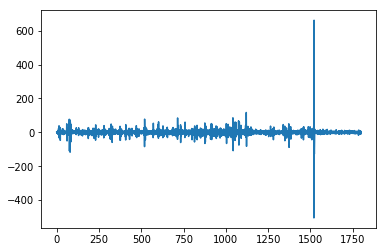

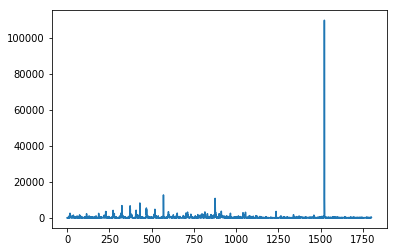

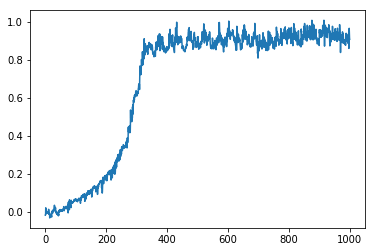

onset_will_happen at 466.0


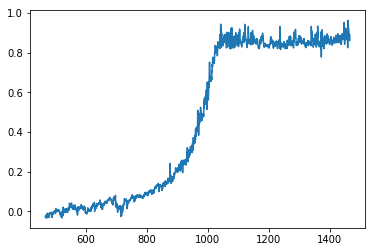

onset_will_happen at 1172.5
/home/maestroj/medical_analysis/validation_csv/sub2_4-22th_validation_eegdata_3.csv is loaded
4400


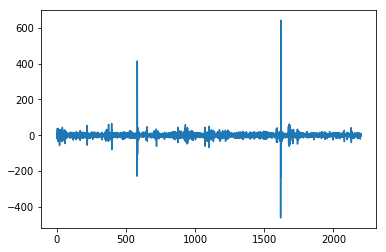

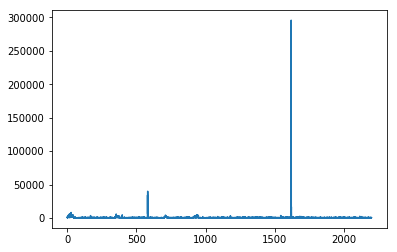

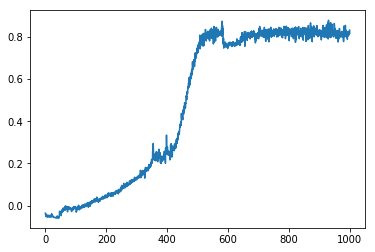

onset_will_happen at 657.5


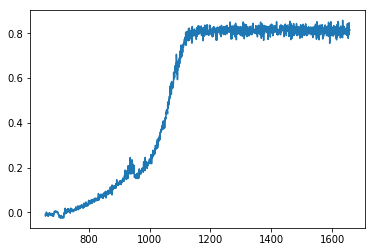

onset_will_happen at 1268.5
/home/maestroj/medical_analysis/validation_csv/sub4_4th_validation_eegdata.csv is loaded


In [ ]:
load_dir = '/home/maestroj/medical_analysis/validation_csv'

for path in glob.glob(load_dir+"/*.csv"):
    start = 0
    result = downgrade_and_feature(validation_load(path))
    time = time_axis_maker(result['averages'],striding/sampling_rate)
    plt.plot(time,result['averages'])
    plt.show()
    plt.plot(time,result['variations'])
    plt.show()
    while(start+test_length<len(result['averages'])):
        input_data = test_set_generator(result, start)
        input_data = np.reshape(input_data,[1,2,test_length])
        temp = sess.run(temp_test_outputs[0], feed_dict = {test_x : input_data})
        time = time_axis_maker(temp,striding/sampling_rate, start*striding/sampling_rate)   
        plt.plot(time, temp)
        plt.show()
        flag = 0
        for i in range(len(temp)):
            if temp[i]>0.8:
                flag = 1
                start+=i+seizure_duration;
                print("onset_will_happen at {}".format(start*striding/sampling_rate))
                break;
        if flag==0:
            start = test_length